# Neurodynamics Simulation

**Contents**

- [brainpy.NeuGroup](#brainpy.NeuGroup)
- [brainpy.TwoEndConn](#brainpy.TwoEndConn)
- [brainpy.Network](#brainpy.Network)

For brain modeling, BrainPy provides the interface of `brainpy.NeuGroup`, `brainpy.TwoEndConn`, and `brainpy.Network` for convenient neurodynamics simulation.

In [1]:
import brainpy as bp
import numpy as np

## brainpy.NeuGroup

`brainpy.NeuGroup` is used for neuron group modeling. User-defined neuron group models must inherit from the `brainpy.NeuGroup`. Let's take the [leaky integrate-and-fire](https://en.wikipedia.org/wiki/Biological_neuron_model#Leaky_integrate-and-fire) (LIF) model and [Hodgkin–Huxley neuron model](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model) as the illustrated examples. 

### LIF model

The formal equations of a LIF model is given by:

$$
\tau_m \frac{dV}{dt} = - (V(t) - V_{rest}) + I(t) 
\\
\text{after}\, V(t) \gt V_{th}, V(t) =V_{rest}
\,
\text{last}\, \tau_{ref}\, \text{ms} 
$$

where $V$ is the membrane potential, $V_{rest}$ is the rest membrane potential, $V_{th}$ is the spike threshold, $\tau_m$ is the time constant, $\tau_{ref}$ is the refractory time period, and $I$ is the time-variant synaptic inputs. 

As stated above, the numerical integration of the differential equation in LIF model can be coded as:

In [2]:
@bp.odeint
def int_V(V, t, Iext, V_rest, R, tau):
    return (- (V - V_rest) + R * Iext) / tau

Then, we will define the following items to store the neuron state:

- ``V``: The membrane potential.
- ``input``: The synaptic input.
- ``spike``: Whether produce a spike.
- ``refractory``: Whether the neuron is in refractory state.
- ``t_last_spike``: The last spike time for calculating refractory state.

Based on these states, the updating logic of LIF model from the current time $t$ to the next time $t+dt$ will be coded as:

In [3]:
class LIF(bp.NeuGroup):
    target_backend = ['numpy', 'numba']

    def __init__(self, size, t_refractory=1., V_rest=0.,
                 V_reset=-5., V_th=20., R=1., tau=10., **kwargs):
        # parameters
        self.V_rest = V_rest
        self.V_reset = V_reset
        self.V_th = V_th
        self.R = R
        self.tau = tau
        self.t_refractory = t_refractory

        # variables
        self.t_last_spike = bp.ops.ones(size) * -1e7
        self.refractory = bp.ops.zeros(size)
        self.input = bp.ops.zeros(size)
        self.spike = bp.ops.zeros(size)
        self.V = bp.ops.ones(size) * V_reset

        super(LIF, self).__init__(size=size, **kwargs)
    
    @staticmethod
    @bp.odeint
    def int_V(V, t, Iext, V_rest, R, tau):
        return (- (V - V_rest) + R * Iext) / tau
    
    def update(self, _t):
        for i in range(self.size[0]):
            if _t - self.t_last_spike[i] <= self.t_refractory:
                self.refractory[i] = 1.
            else:
                self.refractory[0] = 0.
                V = self.int_V(self.V[i], _t, self.input[i], self.V_rest, self.R, self.tau)
                if V >= self.V_th:
                    self.V[i] = self.V_reset
                    self.spike[i] = 1.
                    self.t_last_spike[i] = _t
                else:
                    self.spike[i] = 0.
                    self.V[i] = V
            self.input[i] = 0.

That's all, we have coded a LIF neuron model. 

Each NeuGroup has a powerful function: ``.run()``. In this function, it receives the following arguments:

- ``duration``: Specify the simulation duration. Can be a tuple with ``(start time, end time)``. Or it can be a int to specify the duration ``length`` (then the default start time is ``0``).
- ``inputs``: Specify the inputs for each model component. With the format of ``(target, value, [operation])``. The default operation is ``+``, which means the input ``value`` will be added to the ``target``. Or, the operation can be ``+``, ``-``, ``*``, ``/``, or ``=``.

Now, let's run it.

In [4]:
group = LIF(100, monitors=['V'])

Compilation used 0.0000 s.
Start running ...
Run 10.0% used 0.054 s.
Run 20.0% used 0.121 s.
Run 30.0% used 0.177 s.
Run 40.0% used 0.231 s.
Run 50.0% used 0.283 s.
Run 60.0% used 0.337 s.
Run 70.0% used 0.387 s.
Run 80.0% used 0.440 s.
Run 90.0% used 0.496 s.
Run 100.0% used 0.550 s.
Simulation is done in 0.550 s.



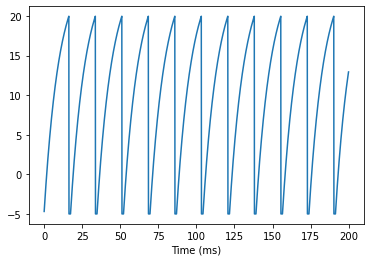

In [5]:
group.run(duration=200., inputs=('input', 26.), report=True)
bp.visualize.line_plot(group.mon.ts, group.mon.V, show=True)

Compilation used 0.0010 s.
Start running ...
Run 10.0% used 0.052 s.
Run 20.0% used 0.108 s.
Run 30.0% used 0.161 s.
Run 40.0% used 0.214 s.
Run 50.0% used 0.273 s.
Run 60.0% used 0.319 s.
Run 70.0% used 0.379 s.
Run 80.0% used 0.432 s.
Run 90.0% used 0.483 s.
Run 100.0% used 0.542 s.
Simulation is done in 0.542 s.



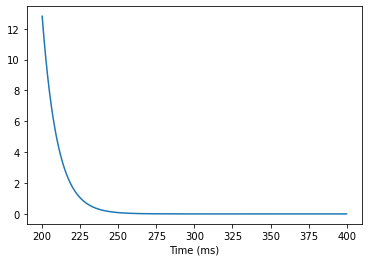

In [6]:
group.run(duration=(200, 400.), report=True)
bp.visualize.line_plot(group.mon.ts, group.mon.V, show=True)

As you experienced just now, the benefit of inheriting `brainpy.NeuGroup` lies at the following several ways:

- Easy way to monitor variable trajectories.
- Powerful "inputs" support.
- Continuous running support. 
- Progress report. 

On the model definition, BrainPy endows you the fully data/logic flow control. You can define models with any data you need and any logic you want. There are little limitations/constrains on your customization. 1, you should set what computing backend do your defined model support by the keyword `target_backend`. 2, you should "super()" initialize the `brainpy.NeuGroup` with the keyword of the group `size`. 3, you should define the `update` function.

### Hodgkin–Huxley model

The updating logic in the above LIF model is coded with a for loop, which is very suitable for Numba backend (because Numba is a Just-In-Time compiler, and it is good at the for loop optimization). However, for array-oriented programming languages, such as NumPy, PyTorch and TensorFlow, this coding schema is inefficient. Here, let's use the HH neuron model as example to demonstrate how to code an array-based neuron model for general backends.

In [7]:
class HH(bp.NeuGroup):
    target_backend = 'general'
    
    @staticmethod
    def diff(V, m, h, n, t, Iext, gNa, ENa, gK, EK, gL, EL, C):
        alpha = 0.1 * (V + 40) / (1 - bp.ops.exp(-(V + 40) / 10))
        beta = 4.0 * bp.ops.exp(-(V + 65) / 18)
        dmdt = alpha * (1 - m) - beta * m

        alpha = 0.07 * bp.ops.exp(-(V + 65) / 20.)
        beta = 1 / (1 + bp.ops.exp(-(V + 35) / 10))
        dhdt = alpha * (1 - h) - beta * h

        alpha = 0.01 * (V + 55) / (1 - bp.ops.exp(-(V + 55) / 10))
        beta = 0.125 * bp.ops.exp(-(V + 65) / 80)
        dndt = alpha * (1 - n) - beta * n

        I_Na = (gNa * m ** 3.0 * h) * (V - ENa)
        I_K = (gK * n ** 4.0) * (V - EK)
        I_leak = gL * (V - EL)
        dVdt = (- I_Na - I_K - I_leak + Iext) / C

        return dVdt, dmdt, dhdt, dndt

    def __init__(self, size, ENa=50., EK=-77., EL=-54.387,
                 C=1.0, gNa=120., gK=36., gL=0.03, V_th=20.,
                 **kwargs):
        # parameters
        self.ENa = ENa
        self.EK = EK
        self.EL = EL
        self.C = C
        self.gNa = gNa
        self.gK = gK
        self.gL = gL
        self.V_th = V_th

        # variables
        self.V = bp.ops.ones(size) * -65.
        self.m = bp.ops.ones(size) * 0.5
        self.h = bp.ops.ones(size) * 0.6
        self.n = bp.ops.ones(size) * 0.32
        self.spike = bp.ops.zeros(size)
        self.input = bp.ops.zeros(size)
        
        self.integral = bp.odeint(f=self.diff, method='rk4', dt=0.01)
        super(HH, self).__init__(size=size, **kwargs)

    def update(self, _t):
        V, m, h, n = self.integral(self.V, self.m, self.h, self.n, _t,
                                   self.input, self.gNa, self.ENa, self.gK,
                                   self.EK, self.gL, self.EL, self.C)
        self.spike = (self.V < self.V_th) * (V >= self.V_th)
        self.V = V
        self.m = m
        self.h = h
        self.n = n
        self.input[:] = 0

In HH example, all the operations (including "zeros", "ones" and "exp") are used from the `brainpy.ops` as `bp.ops.zeros`, `bp.ops.ones` and `bp.ops.exp`. What's more, we set the "target_backend" as `general`, which means it can run on any backends. So, let's try to run this model on various backends.

First is PyTorch.

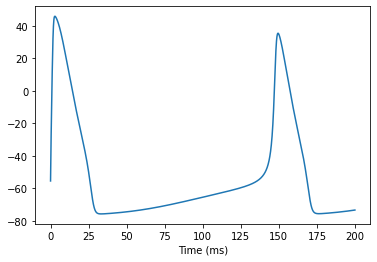

In [8]:
bp.backend.set('pytorch')

group = HH(100, monitors=['V'])
group.run(200., inputs=('input', 10.))
bp.visualize.line_plot(group.mon.ts, group.mon.V, show=True)

Second is NumPy.

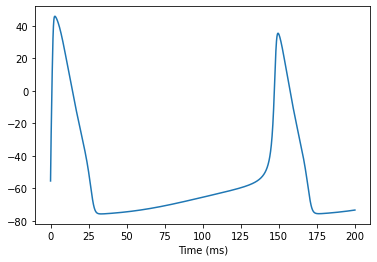

In [9]:
bp.backend.set('numpy')

group = HH(100, monitors=['V'])

group.run(200., inputs=('input', 10.))

bp.visualize.line_plot(group.mon.ts, group.mon.V, show=True)

The last is Numba.

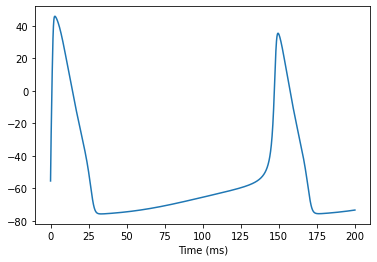

In [10]:
bp.backend.set('numba')

group = HH(100, monitors=['V'])
group.run(200., inputs=('input', 10.))
bp.visualize.line_plot(group.mon.ts, group.mon.V, show=True)

## brainpy.TwoEndConn

For synaptic connections, BrainPy provides `brainpy.TwoEndConn` to help you construct the projection between pre-synaptic and post-synaptic neuron groups, and provides `brainpy.connect.Connector` for synaptic connectivity between pre- and post- groups. 

- The benefit of using `brainpy.TwoEndConn` lies at the **automatical synaptic delay**. The synapse modeling usually includes a delay time (typically 0.3–0.5 ms) required for a neurotransmitter to be released from a presynaptic membrane, diffuse across the synaptic cleft, and bind to a receptor site on the post-synaptic membrane. BrainPy provides `register_constant_dely()` for automatical state delay. 

- Another benefit of using `brainpy.connect.Connector` lies at the **connectivity structure construction**. `brainpy.connect.Connector` provides various synaptic structures, like "pre_ids", "post_ids", "conn_mat", "pre2post", "post2pre", "pre2syn", "post2syn", "pre_slice", and "post_slice". Users can "requires" such data structures by calling `connector.requires('pre_ids', 'post_ids', ...)`. We will detail this function in [Synaptic Connections](../tutorials/efficient_synaptic_computation.ipynb).

Here, let's illustrate how to use `brainpy.TwoEndConn` with the AMPA synapse model.

### AMPA Synapse Model

In [11]:
class AMPA(bp.TwoEndConn):
    target_backend = ['numpy', 'numba']

    def __init__(self, pre, post, conn, delay=0., g_max=0.10, E=0., tau=2.0, **kwargs):
        # parameters
        self.g_max = g_max
        self.E = E
        self.tau = tau
        self.delay = delay

        # connections
        self.conn = conn(pre.size, post.size)
        self.conn_mat = conn.requires('conn_mat')
        self.size = bp.ops.shape(self.conn_mat)

        # variables
        self.s = bp.ops.zeros(self.size)
        self.g = self.register_constant_delay('g', size=self.size, delay_time=delay)

        super(AMPA, self).__init__(pre=pre, post=post, **kwargs)

    @staticmethod
    @bp.odeint(dt=0.01)
    def int_s(s, t, tau):
        return - s / tau

    def update(self, _t):
        self.s = self.int_s(self.s, _t, self.tau)
        for i in range(self.pre.size[0]):
            if self.pre.spike[i] > 0:
                self.s[i] += self.conn_mat[i]
        self.g.push(self.g_max * self.s)
        g = self.g.pull()
        self.post.input -= bp.ops.sum(g, axis=0) * (self.post.V - self.E)

To define a two-end synaptic projection is very much like the NeuGroup. Users need to inherit the `brainpy.TwoEndConn`, and provide the "target_backend" specification, "update" function and then "super()" initialize the parent class. But what different are two aspects: 1. connection. We need construct the synaptic connectivity by "connector.requires". 2. delay. We can register a constant delay variable by "self.register_constant_delay()".

Here, we create a matrix-based connectivity (with the shape of `(num_pre, num_post)`). 

<img src="../_static/syn-example-conn_mat.png" width="400 px" align="left">

And then register a delay variable "self.g" with the shape of `(num_pre, num_post)`.

## brainpy.Network

Now, let's put the above defined HH model and AMPA synapse together to construct a network with `brainpy.Network`.

In [12]:
bp.backend.set('numpy')

In [13]:
group = HH(10, monitors=['V', 'spike'])
syn = AMPA(pre=group, post=group, conn=bp.connect.All2All(), delay=1.5, monitors=['s'])

In [14]:
net = bp.Network(group, syn)
net.run(duration=200., inputs=(group, "input", 20.), report=True)

Compilation used 0.3254 s.
Start running ...
Run 10.0% used 0.060 s.
Run 20.0% used 0.120 s.
Run 30.0% used 0.180 s.
Run 40.0% used 0.250 s.
Run 50.0% used 0.310 s.
Run 60.0% used 0.370 s.
Run 70.0% used 0.420 s.
Run 80.0% used 0.490 s.
Run 90.0% used 0.547 s.
Run 100.0% used 0.611 s.
Simulation is done in 0.611 s.



0.6110615730285645

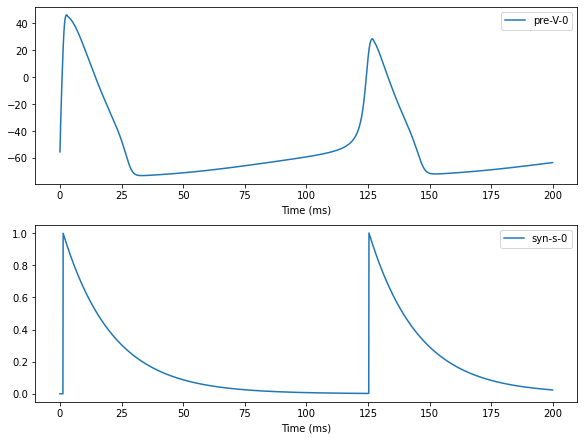

In [15]:
fig, gs = bp.visualize.get_figure(2, 1, 3, 8)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(group.mon.ts, group.mon.V, legend='pre-V')

fig.add_subplot(gs[1, 0])
bp.visualize.line_plot(syn.mon.ts, syn.mon.s, legend='syn-s', show=True)

## Backend-independent Property

Neurodynamics simulation in BrainPy has characteristics of high portability. It's also backend-independent. Currently, BrainPy inherently supports the tensor-oriented backends (such like NumPy, PyTorch, TensorFlow), and the JIT compilers (like Numba). After model coding, users can switch the backend easily by using `brainpy.backend.set(backend_name)`:

In [16]:
# deploy all models to NumPy backend

bp.backend.set('numpy')

In [17]:
# deploy all models to Numba CPU backend

bp.backend.set('numba')

Moreover, customize your preferred backend is also easy. 

In [18]:
bp.ops.OPS_FOR_SIMULATION

['as_tensor', 'zeros', 'ones', 'arange', 'concatenate', 'where', 'reshape']

In [19]:
bp.drivers.set_buffer('numpy', 
                      node_driver=bp.drivers.GeneralNodeDriver,
                      net_driver=bp.drivers.GeneralNetDriver,
                      diffint_driver=bp.drivers.GeneralDiffIntDriver)

---

**Author**:

- Chaoming Wang
- Email: adaduo@outlook.com
- Date: 2021.03.25, update at 2021.05.29

---